### Because running julia from within python kept on failing


Rational

All hitpatterns for fitting are stored in Hitpattern structs, this is since this is a lot easier to handle with the API, I now believe returnign Vector Quantities is possible, however, at the time the struct was the easiest implementation and I have written 
around this.

TemplateExpressions allow for systematic combination of the individual functions, one is used to compute the relevant inputs from the positions, applies the functions to each PMT, and then proceeds to normalize 

Wall Reflection and the Radial LCE response will be fit on MC data

Possibly a more efficient implementation of the anode shadow effects will be implemented from direct naive anode shadow computation 

The remainder will have to be fitted on Neural Network predictions 



So this doesnt seem to work well, it takes very long and the functions dont fit as well as I was hoping

In [1]:
println("Number of threads: ", Threads.nthreads())
run(`egrep --color 'Mem|Cache|Swap' /proc/meminfo`)

Number of threads: 20
MemTotal:       32593832 kB
MemFree:        21318608 kB
MemAvailable:   27412564 kB
Cached:          6640060 kB
SwapCached:            0 kB
SwapTotal:             0 kB
SwapFree:              0 kB


Process(`egrep --color 'Mem|Cache|Swap' /proc/meminfo`, ProcessExited(0))

#### Load Real Data

In [2]:
# We need to load some data 
using PyCall
# Import pandas
pandas = pyimport("pandas")
numpy = pyimport("numpy")
# Load the pickle file
file_path = "/Code/processed_data/all_data_min_filter.pkl.gz"
data = pandas.read_pickle(file_path, compression="gzip")
# Filter non Krypton events 
data = py"$(data)[$(data)['Source'] == 'Kr']"
# To list and np array so we can push it directly into arrays (working on vectors of vectors is a pain)
positions = py"$(numpy).array($(data).position.to_list())"
patterns = py"$(numpy).array($(data).s2_area_per_channel.to_list())"
data = nothing;

LoadError: PyError ($(Expr(:escape, :(ccall(#= /nix/store/358m4ig2m21ph12yydrva2jdmrfhjxm4-julia-depot/depot/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'FileNotFoundError'>
FileNotFoundError(2, 'No such file or directory')
  File "/nix/store/37g69m91hdqdqqiw2qvaz35z684jdmrp-python3-3.11.11-env/lib/python3.11/site-packages/pandas/io/pickle.py", line 185, in read_pickle
    with get_handle(
         ^^^^^^^^^^^
  File "/nix/store/37g69m91hdqdqqiw2qvaz35z684jdmrp-python3-3.11.11-env/lib/python3.11/site-packages/pandas/io/common.py", line 765, in get_handle
    handle = gzip.GzipFile(  # type: ignore[assignment]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nix/store/37g69m91hdqdqqiw2qvaz35z684jdmrp-python3-3.11.11-env/lib/python3.11/gzip.py", line 174, in __init__
    fileobj = self.myfileobj = builtins.open(filename, mode or 'rb')
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
positions = convert(Matrix{Float32}, positions)
patterns = convert(Matrix{Float32}, patterns); 

In [ ]:
# Preprocess data for radial - OUTDATED 

X_for_all_pmt = reshape(positions, size(positions)[1], 1, 2) .- reshape(pmt_pos_numeric, 1, size(pmt_pos_numeric)[1], 2)
X_for_all_pmt = vec(sum(X_for_all_pmt .^2, dims=3))
# minimum gives 0 or neg value (because dead PMT included)
y = patterns[:,not_dead_pmts] .- minimum(patterns,dims=2)
y += 
y ./= reshape(sum(patterns, dims=2), size(patterns)[1], 1)
y = vec(y);

@assert size(X_for_all_pmt)[1] == size(y)[1]

positions = nothing
patterns = nothing

#### Load MC Data

In [2]:
using HDF5
prefix = "/Code"
prefix="/home/felix/Thesis"
path = prefix*"/processed_data/MC/s2_hitpatterns/"

patterns = Array{Float32, 2}(undef, 0, 253)
positions = Array{Float32, 2}(undef, 0, 2)

for i in [i for i in readdir(path) if occursin(".hdf5", i)]
    h5open(path*i, "r") do file
        global patterns
        global positions
        # Extract the datasets
        patterns = vcat(patterns, read(file["hitpatterns"])')
        positions = vcat(positions, hcat(read(file["interface_x"]), read(file["interface_y"]))) #mc
    end
end
#patterns = permutedims(patterns, (2,1));

@assert size(patterns)[1] == size(positions)[1]

#### Load MC Map

More appropriate as a low noise source

Load MC Map without anode shadow to for now only model Wall Reflection and PMT base response

Once this is done the map from incomplete merge can be used to find anode shadow contribution

Note that meshes are part of this but are only treated as an opacity modifier 

In doubt look at the release section I cant  find proper usefull documents outlining MC 


In [2]:
using PyCall
py"""
import os
os.environ["XENON_CONFIG"] = "/Code/xenon.config"
import straxen
downloader = straxen.MongoDownloader()
map_file = downloader.download_single("XENONnT_s2_xy_patterns_topbottom_corrected_MCv3.0.0.pkl")
map_data = straxen.get_resource(map_file, fmt="pkl")
map_interp = straxen.InterpolatingMap(map_data,method='RegularGridInterpolator') 
"""

## Misc load and define

In [3]:
not_dead_pmts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]
not_dead_pmts .+= 1
dead_pmts = [28, 108, 121, 144, 156, 164, 177]
dead_pmts .+= 1
pmt_x = [-13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -1.67313e-05, -6.93766, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5012, 13.8753, 6.93763, -1.46399e-05, -6.93766, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5012, -62.4388, 20.8129, 13.8753, 6.93763, -1.25485e-05, -6.93766, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5012, -62.4388, 27.7506, 20.8129, 13.8753, 6.93763, -1.04571e-05, -6.93765, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5012, -62.4388, 34.6882, 27.7506, 20.8129, 13.8753, 6.93763, -8.36565e-06, -6.93765, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5012, -62.4388, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93764, -6.27423e-06, -6.93765, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5011, -62.4388, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93764, -4.18282e-06, -6.93765, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5011, -62.4388, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93764, -2.09141e-06, -6.93764, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5011, 55.5011, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93764, -0.0, -6.93764, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, -55.5011, 55.5011, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93764, 2.09141e-06, -6.93764, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, 62.4388, 55.5011, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93765, 4.18282e-06, -6.93764, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, -48.5635, 62.4388, 55.5011, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93765, 6.27423e-06, -6.93764, -13.8753, -20.8129, -27.7506, -34.6882, -41.6259, 62.4388, 55.5012, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93765, 8.36565e-06, -6.93763, -13.8753, -20.8129, -27.7506, -34.6882, 62.4388, 55.5012, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93765, 1.04571e-05, -6.93763, -13.8753, -20.8129, -27.7506, 62.4388, 55.5012, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93766, 1.25485e-05, -6.93763, -13.8753, -20.8129, 62.4388, 55.5012, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93766, 1.46399e-05, -6.93763, -13.8753, 55.5012, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753, 6.93766, 1.67313e-05, 48.5635, 41.6259, 34.6882, 27.7506, 20.8129, 13.8753]
pmt_y = [-64.0872, -60.0818, -56.0763, -52.0709, -48.0654, -44.06, -64.0872, -60.0818, -56.0763, -52.0709, -48.0654, -44.06, -40.0545, -36.0491, -32.0436, -64.0872, -60.0818, -56.0763, -52.0709, -48.0654, -44.06, -40.0545, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -60.0818, -56.0763, -52.0709, -48.0654, -44.06, -40.0545, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0164, -56.0763, -52.0709, -48.0654, -44.06, -40.0545, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0164, -8.01092, -4.00547, -52.0709, -48.0654, -44.06, -40.0545, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0164, -8.01091, -4.00546, -1.44897e-05, 4.00544, -48.0654, -44.06, -40.0545, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0164, -8.01091, -4.00546, -1.08673e-05, 4.00544, 8.01089, 12.0163, -44.06, -40.0545, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0164, -8.01091, -4.00546, -7.24486e-06, 4.00544, 8.01089, 12.0163, 16.0218, 20.0272, -36.0491, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0164, -8.0109, -4.00545, -3.62243e-06, 4.00545, 8.0109, 12.0163, 16.0218, 20.0272, 24.0327, -32.0436, -28.0382, -24.0327, -20.0273, -16.0218, -12.0163, -8.0109, -4.00545, 0.0, 4.00545, 8.0109, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, -24.0327, -20.0272, -16.0218, -12.0163, -8.0109, -4.00545, 3.62243e-06, 4.00545, 8.0109, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, -20.0272, -16.0218, -12.0163, -8.01089, -4.00544, 7.24486e-06, 4.00546, 8.01091, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, 40.0545, 44.06, -12.0163, -8.01089, -4.00544, 1.08673e-05, 4.00546, 8.01091, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, 40.0545, 44.06, 48.0654, -4.00544, 1.44897e-05, 4.00546, 8.01091, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, 40.0545, 44.06, 48.0654, 52.0709, 4.00547, 8.01092, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, 40.0545, 44.06, 48.0654, 52.0709, 56.0763, 12.0164, 16.0218, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, 40.0545, 44.06, 48.0654, 52.0709, 56.0763, 60.0818, 20.0273, 24.0327, 28.0382, 32.0436, 36.0491, 40.0545, 44.06, 48.0654, 52.0709, 56.0763, 60.0818, 64.0872, 32.0436, 36.0491, 40.0545, 44.06, 48.0654, 52.0709, 56.0763, 60.0818, 64.0872, 44.06, 48.0654, 52.0709, 56.0763, 60.0818, 64.0872]
pmt_pos_numeric = hcat(pmt_x[not_dead_pmts], pmt_y[not_dead_pmts])
pmt_x_alive = pmt_x[not_dead_pmts]
pmt_y_alive = pmt_y[not_dead_pmts]
R= 66.4;

In [4]:
using SymbolicRegression: ValidVector, TemplateStructure, TemplateExpression, Dataset
using LinearAlgebra: dot, norm

struct Hitpattern
    pmts::Vector{Float32}
end

### ---------------------------------  Loss Functions ----------------------------------------------

function percentage_diff(prediction, target)
    """
    If pmts are inf (flag for invalid equation) select the flaot 1 smaller than typemax (which is inf) -> And reduce to avoid overflow

        Rather unstable for constants
    """
    #cum_perc_diff = sum(abs.(prediction.pmts - target.pmts )  ./ (target.pmts .+ 1e-12) )   prevfloat(typemax(typeof(prediction.pmts[1]))) / 10000
    cum_perc_diff = any(!isfinite, prediction.pmts) ? prevfloat(typemax(typeof(prediction.pmts[1]))) * 1e-10 : sum(abs.(prediction.pmts .- target.pmts) ./ (target.pmts .+ 1e-12))
    return cum_perc_diff
end;


function KL_divergence(prediction, target)
    D_KL = any(!isfinite, prediction.pmts) ? prevfloat(typemax(typeof(prediction.pmts[1]))) * 1e-10 : sum(target.pmts .* log.(target.pmts ./ (prediction.pmts .+ 1e-12)))
    return D_KL
end;


function JS_divergence(prediction, target)
    """
    JS divergence is the average of the KL divergence between the two distributions
    """
    m = Hitpattern(0.5 * (prediction.pmts + target.pmts) )
    D_JS = any(!isfinite, prediction.pmts) ? prevfloat(typemax(typeof(prediction.pmts[1]))) * 1e-10 : 0.5 * KL_divergence(prediction, m) + 0.5 * KL_divergence(target, m)
    return D_JS
end;

function cos_similarity_loss(prediction, target)
    """−1 (completely opposite) to 1 (perfect match). Hence 1- """
    cos_sim = any(!isfinite, prediction.pmts) ? prevfloat(typemax(typeof(prediction.pmts[1]))) * 1e-10 : 1-dot(prediction.pmts, target.pmts) / (norm(prediction.pmts) * norm(target.pmts))
    return cos_sim
end;


function loss_hitpattern(prediction, target)
    loss = 0.0
    # Zero
    targ_min = minimum(target.pmts)
    targ = targ_min > 0 ? target.pmts : target.pmts .-  targ_min
    pred_min = minimum(prediction.pmts)
    pred = pred_min > 0 ? prediction.pmts : prediction.pmts .-  pred_min
    pred = prediction.pmts .* sum(target.pmts) ./ sum(prediction.pmts)

    for (p, t) in zip(pred, targ)
        loss += 2 * (p - t + t * log(t / (p+1e-12)))
    end

    return loss
end

### ---------------------------------  Equation Filtering ----------------------------------------------
import SymbolicRegression

function find_operator(tree, target_operator, operator_type::Symbol)
    """
    Find the Operation Numeric Index
    Note that often it uses internal "safe" representation -> Hence the try catch

    tree : A function tree - Typically TemplateExpression
    target_operator : The function being used internally
    operator_type : Symbol binops or unaops speficying which ops to search
    
    Note that unary adn binary are only distinct by if they have a .r attribute
    """
    try
        # Code that might throw an error
        operators = getfield(tree.metadata.operators, operator_type)
        return findfirst(==(target_operator), operators)
    catch e
        # Handle the error or raise a new exception
        println("Caught exception: ", e)
        println("Internal Representation of Operators")
        println("binary $(tree.metadata.operators.binops)")
        println("unary  $(tree.metadata.operators.unaops)")
        throw(ArgumentError("In find operator"))
    end
end

function find_op_expression(tree, target_op_numeric)
    """
    tree -> Expression to parse
    target_op_numeric -> internal numbering for operations -> Use find_operators
    """
    results = []

    # Check if the current node's operation matches the target
    if tree.op == target_op_numeric
        push!(results, tree)
    end
    # If not, recursively search in the left and right branches
    if isdefined(tree, :l) && !isnothing(tree.l)
        append!(results, find_op_expression(tree.l, target_op_numeric))
    end
    if isdefined(tree, :r) && !isnothing(tree.r)
        append!(results, find_op_expression(tree.r, target_op_numeric))
    end

    return results
end

function check_variable_in_tree(expression)
    """
    Recursive function, idea is one passes a subtree where one wants to find a certain expression
    This calls itself until it finds the variable and then shortcircuits
    """
    # degree == 0 implies const or var 
    if expression.degree == 0
        # Check if a constant or not
        return !expression.constant
    else
        # If any subexpression is true will trigger either return here, else the last false return
        # Check the lhs of subexpression
        if check_variable_in_tree(expression.l)
            return true
        end
        # Check expression is not unary 
        if isdefined(expression, :r)
            # Check the rhs of subexpression
            if check_variable_in_tree(expression.r)
                return true
            end
        end
    end
    return false
end


function find_var_in_power_rhs(composable_equation, tree)
    """
    Checks if there is a subexpression of the form
    g(...) ^ f(x)
    So if x is exponentiated it returns true 
    composable_equation : element of trees array passed to selection function i.e. trees[1]
    tree : The tree to check : ie. composable_equation.trees.functionName.tree
    """
    target_op = SymbolicRegression.CoreModule.OperatorsModule.safe_pow
    # We find the index of target expression
    target_op_idx = find_operator(composable_equation, SymbolicRegression.CoreModule.OperatorsModule.safe_pow, :binops)
    # We find subexpressions containing the operator 
    subexpressions = find_op_expression(tree, target_op_idx)
    # We select the components we want to check - For some reason some are missing the r attribute - no idea why just ignore it 
    subexpressions = [i.r for i in subexpressions if isdefined(i, :r)]
    # return true if any 
    for i in subexpressions
        if check_variable_in_tree(i)
            return true
        end
    end
    return false
end

## -------------------------------- Best function selector --------------------------------------------
"""

Rational for below function
This selects what to place in best_score -> Not the main thing we care about

We dont care about complexity 

Radial LCE:
- We want there to be no terms where x is being exponentiated 


Template expression and loss_function appear to not be compatible 
https://github.com/MilesCranmer/SymbolicRegression.jl/issues/380 - doesnt seem to adress this directly but i cant get it to work
It fails to resolve the expression when both are used in conjunction 

To solve this we need to make the loss faulty in the Template Function itself

"""
function choose_best_loss(; trees, losses::Vector{L}, scores, complexities) where {L<:Real}
    # Return losses
    return argmin(losses)  # Return the index of the minimum loss
end;


In [5]:

function structure_function((; RadialComponent,), (x,y)) 
    """
    To apply functions we iterate PMTs to assure there is only one PMT 
    independent function
    Generate storage for valid in ValidVector for output
    """
    valid = true

    # -----------------------  RadialComponent ----------------------- 
    # Compute radial distance 
    x_shift = x.x[:,:] .- reshape(pmt_x_alive, 1, :)
    y_shift = y.x[:,:] .- reshape(pmt_y_alive, 1, :)
    # Radial dist will also hold the PMT response
    radial_dist = sqrt.(x_shift.^2 .+ y_shift.^2)
    # Radial Dist is of shape (n_elem, n_pmt) - holds final output
    x_shift, y_shift = nothing, nothing


    for i in eachindex(pmt_x_alive)
        # Indexing to maintain singleton
        valid_vec = ValidVector(radial_dist[:,i], valid)
        # 1/ (SomeTerm(rho)) + SomeTerm(rho)
        res = RadialComponent(valid_vec)
        #res2 = RadialComponent2(valid_vec)
        radial_dist[:,i:i] = res.x #.+ res2.x 
        valid &= res.valid# & res2.valid
    end

    # -----------------------  Apply Wall Component ----------------------- 
    # Use PMT to event distance + Event to Wall distance

    #pos_mag = sqrt.(x.x .^2 .+ y.x .^2)
    ## Generate function Input
    #event_wall_dist = abs.(R.-pos_mag)
    #scaling = (R./pos_mag)
    #proj_x = (x.x .* scaling)
    #proj_y = (y.x .* scaling)
    #scaling = nothing

    #for i in eachindex(pmt_x_alive)
        # First input is PMT distance to event sites Wall projection
        # Ie xy * R/mag gives wall point incidence so take abs dist of diff with pmt to get Wall dist
        # Done here to avoid clogging memory with massive array construction
        # TODO Is the shape placed correctly?
    #    res = WallComponent(
    #                        ValidVector(sqrt.((proj_x .- pmt_x_alive[i]).^2 .+ (proj_y .- pmt_y_alive[i]).^2), valid), 
    #                        ValidVector(event_wall_dist,valid)
    #                        )
        # Multiply out the Wall Component per PMT
    #    radial_dist[:,i:i] .*= res.x
    #    valid &= res.valid
    #end

    # Apply Anode Shadow Component

    # Apply Anode Perp Shadow Component

    # Apply Gate + Anode e field component

    # ------------------------ Unwanted Equation Form Flagging ----------------------- 
    # And now we apply our flagging of equation forms we dont want (API bug for overarching loss function)
    # ArgumentRecorder (pre running) tests everything so run only if it has a tree attribute
    # Check should be compiled out for diff input types
    if hasfield(typeof(RadialComponent), :tree)
        # Check If constant
        #if (RadialComponent.tree.constant || WallComponent.tree.constant)
        #    radial_dist .= Inf 
        # Check if to the power of a variable
        if  find_var_in_power_rhs(RadialComponent, RadialComponent.tree)
            radial_dist .= Inf 
        # Apply normalization only if checks passed otherwise inf is fine 
        else
            radial_dist .-= min.(minimum(radial_dist,dims=2), 0)
            radial_dist = radial_dist ./ sum(abs.(radial_dist), dims=2)
        end
    end

    # ----------------------- Return ----------------------- 
    # Generate the ValidVector
    ValidVector([Hitpattern(radial_dist[i, :]) for i in 1:size(radial_dist, 1)], valid)
end


structure = TemplateStructure{Tuple((:RadialComponent,))}(structure_function)

(::TemplateStructure{(:RadialComponent,), typeof(structure_function), @NamedTuple{RadialComponent::Int64}}) (generic function with 0 methods)

In [6]:
n_cpus=nothing
try
    n_cpus = read(`sinfo -N -o "%n %c"`, String)
    println(n_cpus)
    n_cpus = sum(parse.(Int, [split(i, ' ')[2] for i in split(n_cpus, '\n')[2:end-1]]));
    println(read(`sinfo`, String))
catch 
    n_cpus = Threads.nthreads()
end

20

In [21]:
import SymbolicRegression: SRRegressor
#using TensorBoardLogger
import SymbolicRegression.LoggingModule: SRLogger
import ClusterManagers: addprocs_slurm
"""
General Notes

It really like making redundant expressions:
#1/#1 or (#2+#2) to penalize these i set the complexity of constants and variables higher than for operators 



Add inv as a unary operator - I dont quite understand why it isn't finding it -> Check if the base function actually works 

"""

# Wrapper to invoke the correct docker container
function slurm_wrapper(n_procs)
    # See top markdown to generate this file
    addprocs_slurm(n_procs, container="/home/felix/Thesis/Docker_Environments/SymbolicRegressionJulia/jlsroci.oci")
end


# It might be to complicated to search for both simulataneously, maybe split it up into one test set that is center focused and one that is edge focused being evaluated separately
model = nothing
model = SRRegressor(;

    niterations= 10000, 
    #addprocs_function = addprocs_slurm, #### SLURRMMMM
    turbo=false, # EXPERIMENTAL !!!

    #unary_operators=[tanh], # Could be very usefull for setting a maximum slope

    binary_operators=(*, ^, +),
    constraints = [
        (^)=>(-1, 1), 
        (+)=>(-1, -1),
        (*)=>(-1, -1),
        #(tanh) => 3,
        #(/)=>(-1, 6),
    ],
    #nested_constraints =  [
    #    tanh => [tanh => 0], # Do not place tanh in tanh
    #],
    #unary_operators=(sqrt, ),
    # Complexity
    complexity_of_constants = 2,
    complexity_of_operators = [
        #(/) => 1,
        (^) => 1,
        (+) => 1,
        (*) => 1,
    ],
    complexity_of_variables = 1,

    # Specify structure funciton
    expression_type=TemplateExpression,
    expression_options=(; structure=structure),

    # Populations
    # Slurm Specific
    populations = 3*n_cpus, 
    #population_size = 20, #100

    # Maximum equation Size
    maxsize=30, # Sum of eqs not per
    maxdepth=10,

    # To avoid it looking through equations like a+b 
    should_simplify=true,
    should_optimize_constants = true,

    # Annealing
    annealing=true,
    # alpha = 0.1,

    # Parsimony : multiplicative factor for how much complexity is punished 
    parsimony = 0, 
    #adaptive_parsimony_scaling = 1000,
    #use_frequency=true,
    
    # Loss
    elementwise_loss = KL_divergence, # Easiest to compute with acceptable numeric range,  try for now 
    # cos_similarity_loss, # Range 0 to inf - Constants are slightly larger, but low numeric range kind of annoys me 
    #percentage_diff - Doesnt seem to work well , 
    # KL_divergence,  # Range 0 to inf : Naturally assigns high value to const 
    # JS_divergence, # Range 0 to 0.693 : Seems to assign higher value to const as well 
    selection_method = choose_best_loss, 

    # Batching 
    #batching=true,
    #batch_size=2^4,

    #seed = 111, # Start Seed
    #logger = SRLogger(TBLogger("logs/run"), log_interval=1), # Go into container do: tensorboard --logdir logs/ --port 6006 --bind_all :: and go to link localhost:6006 <- Kinda useless

    save_to_file=true,
);

In [22]:
### Testing with pre determined radial LCE
function compute_PMT_distances( x_coords::AbstractVector{<:AbstractFloat}, 
                                y_coords::AbstractVector{<:AbstractFloat}, 
                                pmt_x_alive::AbstractVector{<:AbstractFloat} = pmt_x_alive, 
                                pmt_y_alive::AbstractVector{<:AbstractFloat} = pmt_y_alive)
    # Preallocate 
    num_samples = length(x_coords)
    num_pmts = length(pmt_x_alive)
    distances = Array{Float64}(undef, num_samples, num_pmts)
    # Compute distances
    for i in 1:num_samples
        for j in 1:num_pmts
            distances[i, j] = sqrt((x_coords[i] - pmt_x_alive[j])^2 + (y_coords[i] - pmt_y_alive[j])^2)
        end
    end
    return distances
end
function compute_PMT_distances(x_coords::Vector{<:AbstractFloat}, y_coords::Vector{<:AbstractFloat}) # Wrapper
    compute_PMT_distances(x_coords, y_coords, pmt_x_alive, pmt_y_alive)
end
    
function RadialLCE(rho::AbstractMatrix{<:AbstractFloat})
    """
    Use found function to test this 
    """
    p, d, a, b = 1.6266745e+00,  9.4918861e+00, -4.2176653e-05,  7.7804564e-03
    @. ((1 - b) / (1 + (rho / d)^2)^p) + (a .* rho) + b
end
function RadialLCE(x::AbstractVector{<:AbstractFloat}, y::AbstractVector{<:AbstractFloat}) # Wrapper
    RadialLCE(compute_PMT_distances(x, y, pmt_x_alive, pmt_y_alive))
end
if false
    n_points = 100

    # Elevate low R contribution
    X = (;
        x=pmt_x[1:n_points] .+ rand(n_points)/4 .- 0.25/2,#rand(n_points) .* (66.4) .- 66.4/2,
        y=pmt_y[1:n_points] .+ rand(n_points)/4 .- 0.25/2#rand(n_points) .* (66.4) .- 66.4/2,
    );

    tmp = RadialLCE(X.x, X.y)
    tmp .-= min.(minimum(tmp, dims=2),0)
    tmp ./= sum(tmp, dims=2)
    y = [Hitpattern(tmp[i, :]) for i in 1:n_points];
end

In [23]:
# Generate Points

n_points = 100

X = (;
        x=(rand(n_points) .* (66.4) .- 66.4/2)/16,# Within 4.5 cm of center
        y=(rand(n_points) .* (66.4) .- 66.4/2)/16,
    );

pos = cat(X.x, X.y, dims = 2)
tmp = py"""map_interp($pos)"""[:,not_dead_pmts]
tmp ./= sum(tmp, dims=2)#./100
y = [Hitpattern(tmp[i, :]) for i in 1:size(tmp)[1]];

In [24]:
using MLJBase: machine, fit!, predict, report
using LoopVectorization #For turbo
mach = nothing
mach = machine(model, X, y)
# Temp Debug
#Base.length(h::Hitpattern) = throw(MethodError("Base.length is not defined for Hitpattern"))#length(h.pmts)
#Base.iterate(h::Hitpattern, state=1) = throw(MethodError("Base.iterate is not defined for Hitpattern"))#state <= length(h.pmts) ? (h.pmts[state], state + 1) : nothing

untrained Machine; caches model-specific representations of data
  model: SRRegressor(defaults = nothing, …)
  args: 
    1:	Source @157 ⏎ ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}
    2:	Source @260 ⏎ AbstractVector{ScientificTypesBase.Unknown}


In [25]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear) # So the warning goes away :clear, alternate :append
fit!(mach) 

Evolving for 10000 iterations... 100%|███████████████████| Time: 2 days, 14:15:03
[ Info: Final population:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.022e+00  3.604e+01  RadialComponent = #1
2           1.575e+00  6.517e-01  RadialComponent = 0.028158
4           9.403e-01  2.578e-01  RadialComponent = #1 * -0.86147
6           6.026e-01  2.224e-01  RadialComponent = (#1 + -104.8) * #1
7           1.033e-01  1.764e+00  RadialComponent = (#1 + 8.8695) ^ -3.148
27          1.004e-01  1.418e-03  RadialComponent = (((((#1 + -46.344) * (#1 + -30.97)) * -0.178...
                                  36) * (#1 + -30.97)) * (#1 + -60.553)) * (#1 + -60.552)
29          9.139e-02  4.702e-02  RadialComponent = (#1 + -53.81) * ((#1 + -80.239) * ((#1 + -53...
                                  .81) * (((#1 + -35.665) * (#1 + -35.665)) * (#1 + -35.665))))
───────────────────────────────────────────────────────────────────────────────────────────────────


[ Info: Results saved to:


  - outputs/20250201_182624_hCvkJd/hall_of_fame.csv


trained Machine; caches model-specific representations of data
  model: SRRegressor(defaults = nothing, …)
  args: 
    1:	Source @157 ⏎ ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}
    2:	Source @260 ⏎ AbstractVector{ScientificTypesBase.Unknown}


In [26]:
r = report(mach)
# Best match is complexity weigthed
println("Best equation used: ", r.equation_strings[r.best_idx])

println("All equations")
println("n : Loss : Score : Equation")
for i in eachindex(r.losses)
    println("$(i) : $(r.losses[i]) : $(r.scores[i]) : $(r.equation_strings[i])")
end
loss = r.losses
loss = ifelse.(isnan.(loss), Inf, loss)
min_loss = argmin(loss)
min_score = argmin(r.scores)
println("\nMinimum Loss index: $(min_loss)")
println("Minimum Score index: $(min_score)")
println("Best index: $(r.best_idx)")

Best equation used: RadialComponent = (#1 + -53.81029133218199) * ((#1 + -80.23898274506872) * ((#1 + -53.81029133218199) * (((#1 + -35.66494602091983) * (#1 + -35.66494602091983)) * (#1 + -35.66494602091983))))
All equations
n : Loss : Score : Equation
1 : 3.0215466728261857 : 36.04365338911715 : RadialComponent = #1
2 : 1.5747650002760767 : 0.6516627886347481 : RadialComponent = 0.028157805089372646
3 : 0.9402913637553928 : 0.2578357726378158 : RadialComponent = #1 * -0.8614701345318238
4 : 0.6026489269433185 : 0.222427486104356 : RadialComponent = (#1 + -104.79868706790046) * #1
5 : 0.10329239899075204 : 1.763771024940913 : RadialComponent = (#1 + 8.86953827012066) ^ -3.147956845663975
6 : 0.10040508935903619 : 0.001417544736413027 : RadialComponent = (((((#1 + -46.34421998559905) * (#1 + -30.970339253272073)) * -0.17836401750889966) * (#1 + -30.970339253272073)) * (#1 + -60.552908914157435)) * (#1 + -60.55223157221256)
7 : 0.09139311420448282 : 0.047021379054535385 : RadialComponen

In [27]:
# Compute KL Divergence for Radial LCE on same pos

tmp = RadialLCE(X.x, X.y)

tmp .-= min.(minimum(tmp, dims=2),0)

tmp ./= sum(tmp, dims=2)

rlce_kl = KL_divergence.([Hitpattern(i) for i in eachrow(tmp)], y)
println("KL Divergence for Radial LCE: ", sum(rlce_kl)/length(rlce_kl))

KL Divergence for Radial LCE: 0.1049418566404361


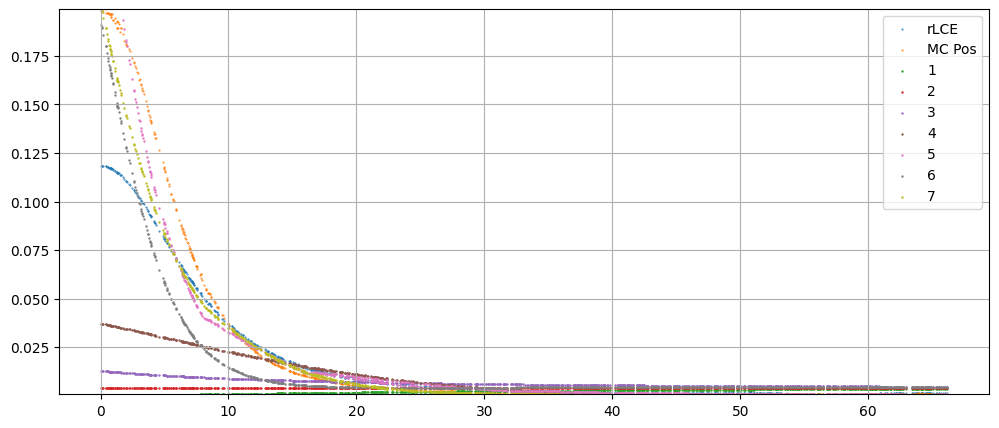

In [34]:
using PyPlot
y =rand(1000)*(66.4*2).-66.4
x =zeros(1000)
idx_pmt = findall(x->x==0, pmt_x_alive)[1]

R = sqrt.((x .- pmt_x_alive[idx_pmt]).^2 .+ (y  .- pmt_x_alive[idx_pmt]).^2)

tmp = RadialLCE(x, y)
tmp ./= sum(tmp, dims=2)
tmp = [Hitpattern(tmp[i, :]) for i in 1:1000];
tmp = permutedims(hcat([i.pmts for i in tmp]...),(2,1))

plt.figure(figsize=(12,5))

plt.scatter(R, tmp[:,idx_pmt], s=0.2, label="rLCE")

pos = cat(x, y, dims = 2)
tmp = py"""map_interp($pos)"""[:,not_dead_pmts]
tmp ./= sum(tmp, dims=2)

plt.scatter(R, tmp[:, idx_pmt],s=0.2, label="MC Pos")

for i in eachindex(r.losses)
    if isfinite(r.losses[i])
        res = structure_function((r.equations[i]).trees, (ValidVector(x, true), ValidVector(y, true)))
        plt.scatter(R, permutedims(hcat([i.pmts for i in res.x]...), (2,1))[:,idx_pmt], s=0.5, label="$(i)")
    end
end
plt.ylim(minimum(tmp[:,idx_pmt]),maximum(tmp[:,idx_pmt]))
plt.legend()
plt.grid()
plt.show()

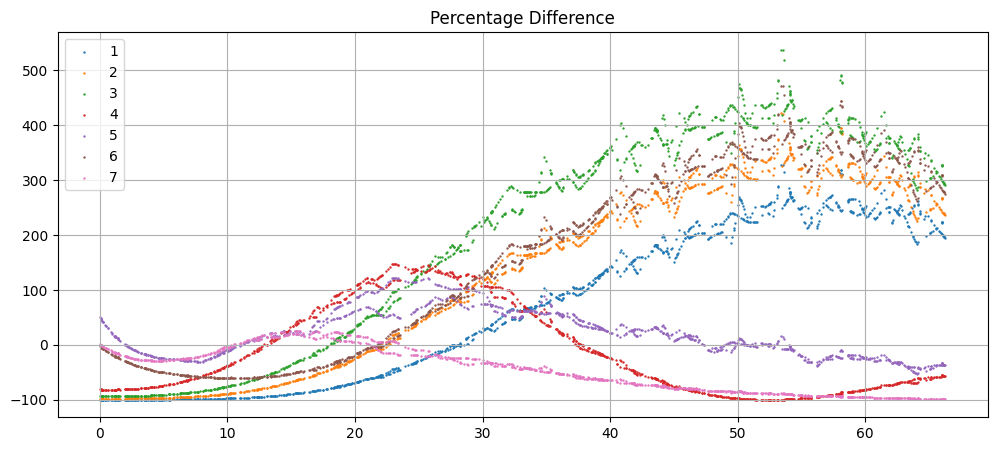

In [39]:
using PyPlot
y =rand(1000)*(66.4*2).-66.4
x =zeros(1000)
idx_pmt = findall(x->x==0, pmt_x_alive)[1]

R = sqrt.((x .- pmt_x_alive[idx_pmt]).^2 .+ (y  .- pmt_x_alive[idx_pmt]).^2)

tmp = RadialLCE(x, y)
tmp ./= sum(tmp, dims=2)
tmp = [Hitpattern(tmp[i, :]) for i in 1:1000];
tmp = permutedims(hcat([i.pmts for i in tmp]...),(2,1))

plt.figure(figsize=(12,5))

#plt.scatter(R, tmp[:,idx_pmt], s=0.2, label="rLCE")

pos = cat(x, y, dims = 2)
tmp = py"""map_interp($pos)"""[:,not_dead_pmts]
tmp ./= sum(tmp, dims=2)

#plt.scatter(R, tmp[:, idx_pmt],s=0.2, label="MC Pos")

for i in eachindex(r.losses)
    if isfinite(r.losses[i])
        res = structure_function((r.equations[i]).trees, (ValidVector(x, true), ValidVector(y, true)))
        perc_diff = (permutedims(hcat([i.pmts for i in res.x]...), (2,1))[:,idx_pmt].-tmp[:, idx_pmt])./tmp[:, idx_pmt] .* 100
        plt.scatter(R, perc_diff, s=0.5, label="$(i)")
    end
end
plt.title("Percentage Difference")
#plt.ylim(minimum(tmp[:,idx_pmt]),maximum(tmp[:,idx_pmt]))
plt.legend()
plt.grid()
plt.show()